In [1]:
# TBD 2: flask github 참고, method, class, 파일의 맨 윗단 마다 pydoc 형식으로 달기
# TBD 3: 축약어를 자제할것 (특히 변수)

# tensorflow Module
import tensorflow as tf
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau
# external Module
import numpy as np
import segmentation_models as sm

# basic Module
import os
from datetime import datetime
from glob import glob

from gan_module.data_loader.segmentation import SegDataloader
from gan_module.util import custom_loss
from gan_module.util.custom_loss import WeightedRegionLoss, TverskyLoss, dice_score, dice_loss
from gan_module.config import CONFIG


custom_loss.AXIS = [1, 2]
USE_GPU = True
# set GPU memory growth allocation
if USE_GPU :
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)


class UnetSegmentation:
    def __init__(
        self,
        dataset_name,
        generator_learning_rate=1e-4,
    ):

        img_shape = CONFIG["img_shape"]
        input_channels = CONFIG["input_channels"]
        output_channels = CONFIG["output_channels"]

#         Configure data loader
        train_image_path_list = glob(
            f"./datasets/{dataset_name}/train/image/*.png")
        train_mask_path_list = glob(
            f"./datasets/{dataset_name}/train/mask/*.png")
        valid_image_path_list = glob(
            f"./datasets/{dataset_name}/valid/image/*.png")
        valid_mask_path_list = glob(
            f"./datasets/{dataset_name}/valid/mask/*.png")

        self.train_data_loader = SegDataloader(
            image_path_list=train_image_path_list,
            mask_path_list=train_mask_path_list,
            batch_size=4,
            shuffle=True,
            backbone=BACKBONE,
        )
        self.valid_data_loader = SegDataloader(
            image_path_list=valid_image_path_list,
            mask_path_list=valid_mask_path_list,
            batch_size=4,
            shuffle=True,
            backbone=BACKBONE,
        )
        # Number of filters in the first layer of G and D
        self.generator_learning_rate = generator_learning_rate
        generator_optimizer = Nadam(self.generator_learning_rate, clipnorm=1)

        self.generator = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, input_channels), classes=output_channels, activation='sigmoid')
        # loss = sm.losses.bce_dice_loss
        self.generator.compile(
            loss=WeightedRegionLoss(),
            optimizer=generator_optimizer,
            metrics=[dice_score],
        )

    def train(self, epochs, batch_size=4, start_epoch=0):

        start_time = datetime.now()
        self.train_data_loader.batch_size = batch_size
        self.valid_data_loader.batch_size = batch_size
        # loss, val_loss
        save_c = ModelCheckpoint(
            "./U_net/weights_{epoch:02d}_{loss:.4f}.hdf5",
            monitor='val_loss',
            verbose=0,
            save_best_only=False,
            save_weights_only=True,
            mode='min')

        reduceLROnPlat = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=10,
            verbose=1,
            mode="auto",
            min_delta=0.0001,
            cooldown=5,
            min_lr=1e-9)
        csv_logger = CSVLogger('./U_net/log.csv', append=False, separator=',')

        self.generator.fit(
            self.train_data_loader,
            validation_data=self.valid_data_loader,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[reduceLROnPlat, save_c, csv_logger],
            initial_epoch=start_epoch
        )

        elapsed_time = datetime.now() - start_time
        print(f"elapsed_time : {elapsed_time}")


Segmentation Models: using `keras` framework.
{'img_shape': [512, 512], 'input_channels': 3, 'output_channels': 1}
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
generator_lr = 1e-4
dataset_name = "vessel_level_1_512_random_org"
batch_size = 4
g_lr = generator_lr * batch_size
gan = UnetSegmentation(dataset_name=dataset_name, generator_learning_rate=g_lr)

In [3]:
gan.generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
#gan.find_error = True
# gan.generator.load_weights("./U_net/weights_98_0.1090.hdf5")
gan.train(epochs=325, batch_size=batch_size, start_epoch=0)

Epoch 1/325
700/700 [==============================] - 262s 328ms/step - loss: 0.1003 - dice_score: 0.3829 - val_loss: 4.1093 - val_dice_score: 0.1517
Epoch 2/325
700/700 [==============================] - 227s 324ms/step - loss: 0.0582 - dice_score: 0.4980 - val_loss: 4.4934 - val_dice_score: 0.1517
Epoch 3/325
700/700 [==============================] - 224s 320ms/step - loss: 0.0510 - dice_score: 0.5375 - val_loss: 1.7453 - val_dice_score: 0.1448
Epoch 4/325
700/700 [==============================] - 225s 322ms/step - loss: 0.0425 - dice_score: 0.5857 - val_loss: 1.7260 - val_dice_score: 0.1462
Epoch 5/325
700/700 [==============================] - 260s 372ms/step - loss: 0.0369 - dice_score: 0.6158 - val_loss: 5.3646 - val_dice_score: 0.1517
Epoch 6/325
700/700 [==============================] - 224s 320ms/step - loss: 0.0345 - dice_score: 0.6300 - val_loss: 0.2812 - val_dice_score: 0.1063
Epoch 7/325
700/700 [==============================] - 218s 312ms/step - loss: 0.0351 - dice_s

KeyboardInterrupt: 

In [25]:
import csv

with open('./U_net/vessel_level_1_512_random_org/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']


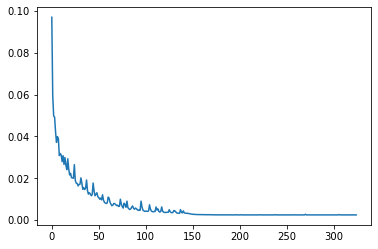

In [30]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["loss"])
plt.show()

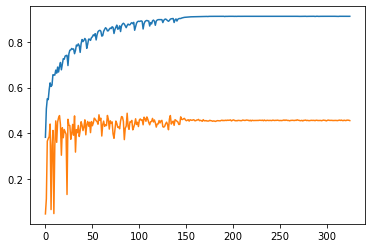

In [32]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["dice_score"])
plt.plot(dict_from_csv["val_dice_score"])
plt.show()

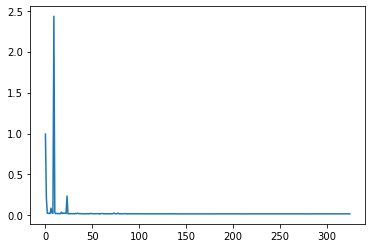

In [29]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["val_loss"])
plt.show()